In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image
from io import BytesIO

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
%matplotlib inline

In [7]:
#  参数设定
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#  超参设定
BATCH_SIZE = 128
LEARNING_RATE = 0.00001
NUM_EPOCHS = 60
RANDOM_SEED = 1
NUM_FEATURES = 784

NUM_CLASSES = 3
GRAYSCALE = False

In [3]:
#  创建白人、黑人及其他人种的数据集
class RaceDatasetsThree(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[1] == 'white':
                self.y.append(0)
            elif i.split('.')[1] == 'black':
                self.y.append(1)
            elif i.split('.')[1] == 'asian':
                self.y.append(2)
            elif i.split('.')[1] == 'hispanic':
                self.y.append(2)
            elif i.split('.')[1] == 'other':
                self.y.append(2)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
custom_transform1 = transforms.Compose([transforms.Resize([128, 128]),
                                       transforms.ToTensor()])

train_dataset = RaceDatasetsThree(img_dir = os.path.join('facedata', 'train'),
                            transform=custom_transform1)

train_loader = DataLoader(dataset = train_dataset,
                        batch_size = 256,
                        shuffle = False)

train_mean = []
train_std = []


for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.1876, 0.1876, 0.1876])
Std Dev: tensor([0.2800, 0.2800, 0.2800])


In [4]:
#  三种类数据集

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}

train_dataset = RaceDatasetsThree(img_dir = os.path.join('facedata', 'train'),
                            transform=data_transforms['train'])

train_loader = DataLoader(dataset = train_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_dataset = RaceDatasetsThree(img_dir = os.path.join('facedata', 'test'),
                            transform=data_transforms['test'])

test_loader = DataLoader(dataset = test_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])


In [8]:
#  模型
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(512 * 4 * 4, 4096)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(4096, 512 * block.expansion)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        # x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [9]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    
def every_kind_accuracy(model, data_loader, device):
    classes = ['WHITE', 'BLACK', 'OTHER']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    every_kind = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        for label, prediction in zip(targets, predicted_labels):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        every_kind.append(accuracy)
    return every_kind

def expand_sample_short(features, targets):
    all_white = 0
    b = []
    if targets.shape[0] != 128:
        return features, all_white
    for idy, target in enumerate(targets):
        if target != 0:
            b.append(idy)

    features1 = features.detach().clone()[b]
    if len(b) == 0:
        all_white = 1
        return features, all_white
    else:
        trade = 128 % len(b)
    ans = 128 // features1.shape[0]

    features2 = features1
    for _ in range(ans - 1):
        features2 = torch.cat([features2, features1], dim = 0)
    if trade > 0:
        features2 = torch.cat([features2, features1[0:trade]])
        
    #print(features2.shape)
    return features2, all_white

    #print(trade, features1.shape, features2.shape)
   


start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []
WHITE_ACC, BLACK_ACC, OTHER_ACC = [], [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        '''
        ### SAMPLE EXPAND
        expand_sample, white_flag = expand_sample_short(features, targets)
        if white_flag == 1:
            continue
        expand_sample.to(DEVICE)
        logits, probas = model(expand_sample)
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0,11.0,44.0,91.0,169.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        '''
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0, 1.0, 1.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 8:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        every_acc = every_kind_accuracy(model, test_loader, device = DEVICE)
        WHITE_ACC.append(every_acc[0])
        BLACK_ACC.append(every_acc[1])
        OTHER_ACC.append(every_acc[2])
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/060 | Batch 000/021 | Cost: 1.0952
Epoch: 001/060 | Batch 008/021 | Cost: 0.9377
Epoch: 001/060 | Batch 016/021 | Cost: 0.7908
Accuracy for class WHITE is: 0.0 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 100.0 %
Epoch: 001/060 Train Acc.: 60.87% | test Acc.: 2.40%
Time elapsed: 0.30 min
Epoch: 002/060 | Batch 000/021 | Cost: 0.7481
Epoch: 002/060 | Batch 008/021 | Cost: 0.7187
Epoch: 002/060 | Batch 016/021 | Cost: 0.6792
Accuracy for class WHITE is: 4.2 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 95.8 %
Epoch: 002/060 Train Acc.: 61.60% | test Acc.: 5.91%
Time elapsed: 0.60 min
Epoch: 003/060 | Batch 000/021 | Cost: 0.6970
Epoch: 003/060 | Batch 008/021 | Cost: 0.6015
Epoch: 003/060 | Batch 016/021 | Cost: 0.6133
Accuracy for class WHITE is: 72.2 %
Accuracy for class BLACK is: 0.0 %
Accuracy for class OTHER is: 20.8 %
Epoch: 003/060 Train Acc.: 74.59% | test Acc.: 61.92%
Time elapsed: 0.89 min
Epoch: 004/060 | Batch 000/021 | Cost

Accuracy for class WHITE is: 69.9 %
Accuracy for class BLACK is: 68.3 %
Accuracy for class OTHER is: 35.4 %
Epoch: 026/060 Train Acc.: 97.80% | test Acc.: 68.89%
Time elapsed: 7.91 min
Epoch: 027/060 | Batch 000/021 | Cost: 0.0781
Epoch: 027/060 | Batch 008/021 | Cost: 0.0557
Epoch: 027/060 | Batch 016/021 | Cost: 0.0872
Accuracy for class WHITE is: 78.9 %
Accuracy for class BLACK is: 76.7 %
Accuracy for class OTHER is: 20.8 %
Epoch: 027/060 Train Acc.: 97.14% | test Acc.: 77.20%
Time elapsed: 8.21 min
Epoch: 028/060 | Batch 000/021 | Cost: 0.0988
Epoch: 028/060 | Batch 008/021 | Cost: 0.1434
Epoch: 028/060 | Batch 016/021 | Cost: 0.0919
Accuracy for class WHITE is: 74.6 %
Accuracy for class BLACK is: 79.5 %
Accuracy for class OTHER is: 25.0 %
Epoch: 028/060 Train Acc.: 98.07% | test Acc.: 74.05%
Time elapsed: 8.52 min
Epoch: 029/060 | Batch 000/021 | Cost: 0.0584
Epoch: 029/060 | Batch 008/021 | Cost: 0.0687
Epoch: 029/060 | Batch 016/021 | Cost: 0.1076
Accuracy for class WHITE is: 81

Epoch: 052/060 | Batch 000/021 | Cost: 0.0435
Epoch: 052/060 | Batch 008/021 | Cost: 0.0253
Epoch: 052/060 | Batch 016/021 | Cost: 0.0246
Accuracy for class WHITE is: 82.8 %
Accuracy for class BLACK is: 77.9 %
Accuracy for class OTHER is: 18.8 %
Epoch: 052/060 Train Acc.: 98.72% | test Acc.: 80.61%
Time elapsed: 15.86 min
Epoch: 053/060 | Batch 000/021 | Cost: 0.0414
Epoch: 053/060 | Batch 008/021 | Cost: 0.0681
Epoch: 053/060 | Batch 016/021 | Cost: 0.0417
Accuracy for class WHITE is: 79.0 %
Accuracy for class BLACK is: 59.8 %
Accuracy for class OTHER is: 22.9 %
Epoch: 053/060 Train Acc.: 99.34% | test Acc.: 75.25%
Time elapsed: 16.17 min
Epoch: 054/060 | Batch 000/021 | Cost: 0.0030
Epoch: 054/060 | Batch 008/021 | Cost: 0.0143
Epoch: 054/060 | Batch 016/021 | Cost: 0.0182
Accuracy for class WHITE is: 87.6 %
Accuracy for class BLACK is: 60.2 %
Accuracy for class OTHER is: 14.6 %
Epoch: 054/060 Train Acc.: 99.54% | test Acc.: 82.46%
Time elapsed: 16.48 min
Epoch: 055/060 | Batch 000/0

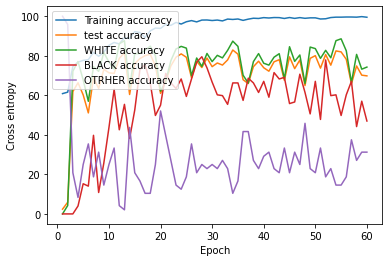

In [12]:
for i in range(len(train_acc_lst)):
    train_acc_lst[i] = train_acc_lst[i].cpu()
    
for j in range(len(test_acc_lst)):
    test_acc_lst[j] = test_acc_lst[j].cpu()

plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='test accuracy')
plt.plot(range(1, NUM_EPOCHS+1), WHITE_ACC, label='WHITE accuracy')
plt.plot(range(1, NUM_EPOCHS+1), BLACK_ACC, label='BLACK accuracy')
plt.plot(range(1, NUM_EPOCHS+1), OTHER_ACC, label='OTRHER accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

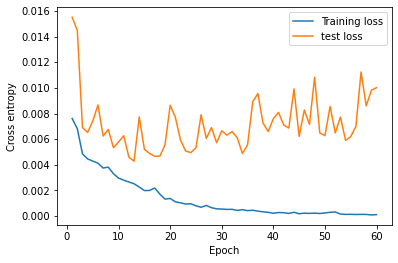

In [13]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [14]:
# 抽取测试集中小样本人种组成新的测试集
import shutil

def mycopyfile(srcdir,srcfadir):
    
    # 判断样本所属人种
    for fname in os.listdir(srcdir):
        if not fname.endswith('.png'):
            continue
        
        _, race, _ = fname.split('.')
        
        srcfile = srcdir + fname
        if race == 'white':
            continue
        elif race == 'black':
            continue
        elif race == 'asian':
            dstfile = srcfadir + fname
            shutil.copyfile(srcfile, dstfile)      #复制文件
            # print("copy %s -> %s" %( srcfile,dstfile))
        elif race == 'hispanic':
            dstfile = srcfadir + fname
            shutil.copyfile(srcfile, dstfile)      #复制文件
            # print("copy %s -> %s" %( srcfile,dstfile))
        elif race == 'other':
            dstfile = srcfadir+ fname
            shutil.copyfile(srcfile, dstfile)      #复制文件
            # print("copy %s -> %s" %( srcfile,dstfile))
    
src = '/home/rush/Face_Recognize/facedata/test/'
srcfa = '/home/rush/Face_Recognize/facedata/threetest/'

mycopyfile(src, srcfa)

In [30]:
#  创建小样本数据集
class RaceDatasetsLow(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[1] == 'asian':
                self.y.append(0)
            elif i.split('.')[1] == 'hispanic':
                self.y.append(1)
            elif i.split('.')[1] == 'other':
                self.y.append(2)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
custom_transform1 = transforms.Compose([transforms.Resize([128, 128]),
                                       transforms.ToTensor()])

train_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetrain'),
                            transform=custom_transform1)

train_loader = DataLoader(dataset = train_dataset,
                        batch_size = 256,
                        shuffle = False)

train_mean = []
train_std = []


for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.2077, 0.2077, 0.2077])
Std Dev: tensor([0.2873, 0.2873, 0.2873])


In [31]:
#  小样本数据集
BATCH_SIZE = 48

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}

train_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetrain'),
                            transform=data_transforms['train'])

train_loader = DataLoader(dataset = train_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetest'),
                            transform=data_transforms['test'])

test_loader = DataLoader(dataset = test_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([48, 3, 128, 128])
Image label dimensions: torch.Size([48])
Image batch dimensions: torch.Size([48, 3, 128, 128])
Image label dimensions: torch.Size([48])


In [36]:
torch.manual_seed(RANDOM_SEED)

model_low = resnet18(NUM_CLASSES)
model_low.to(DEVICE)

optimizer = torch.optim.Adam(model_low.parameters(), lr=LEARNING_RATE)

In [37]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    
def every_kind_accuracy(model, data_loader, device):
    classes = ['ASIAN', 'HISPANIC', 'OTHER']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    every_kind = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        for label, prediction in zip(targets, predicted_labels):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        #print(total_pred)
            
    for classname, correct_count in correct_pred.items():
        if(total_pred[classname] == 0):
            accuracy = 0.1
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            every_kind.append(accuracy)
        else:
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            every_kind.append(accuracy)
    return every_kind

def expand_sample_short(features, targets):
    all_white = 0
    b = []
    if targets.shape[0] != 128:
        return features, all_white
    for idy, target in enumerate(targets):
        if target != 0:
            b.append(idy)

    features1 = features.detach().clone()[b]
    if len(b) == 0:
        all_white = 1
        return features, all_white
    else:
        trade = 128 % len(b)
    ans = 128 // features1.shape[0]

    features2 = features1
    for _ in range(ans - 1):
        features2 = torch.cat([features2, features1], dim = 0)
    if trade > 0:
        features2 = torch.cat([features2, features1[0:trade]])
        
    #print(features2.shape)
    return features2, all_white

    #print(trade, features1.shape, features2.shape)
   


start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []
ASIAN_ACC, HISPANIC_ACC, OTHER_ACC = [], [], []

for epoch in range(NUM_EPOCHS):
    
    model_low.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        '''
        ### SAMPLE EXPAND
        expand_sample, white_flag = expand_sample_short(features, targets)
        if white_flag == 1:
            continue
        expand_sample.to(DEVICE)
        logits, probas = model(expand_sample)
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0,11.0,44.0,91.0,169.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        '''
            
        ### FORWARD AND BACK PROP
        logits, probas = model_low(features)
        loss_with_weight = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0, 1.0, 1.0])).float())
        loss_with_weight.cuda()
        cost = loss_with_weight(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 8:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model_low.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model_low, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model_low, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        every_acc = every_kind_accuracy(model_low, test_loader, device = DEVICE)
        ASIAN_ACC.append(every_acc[0])
        HISPANIC_ACC.append(every_acc[1])
        OTHER_ACC.append(every_acc[2])
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/060 | Batch 000/033 | Cost: 1.0714
Epoch: 001/060 | Batch 008/033 | Cost: 1.0848
Epoch: 001/060 | Batch 016/033 | Cost: 1.1264
Epoch: 001/060 | Batch 024/033 | Cost: 1.1149
Epoch: 001/060 | Batch 032/033 | Cost: 1.0662
Accuracy for class ASIAN is: 96.2 %
Accuracy for class HISPANIC is: 30.8 %
Accuracy for class OTHER is: 0.0 %
Epoch: 001/060 Train Acc.: 36.34% | test Acc.: 60.42%
Time elapsed: 0.12 min
Epoch: 002/060 | Batch 000/033 | Cost: 1.0606
Epoch: 002/060 | Batch 008/033 | Cost: 1.0664
Epoch: 002/060 | Batch 016/033 | Cost: 1.1355
Epoch: 002/060 | Batch 024/033 | Cost: 1.0894
Epoch: 002/060 | Batch 032/033 | Cost: 1.0933
Accuracy for class ASIAN is: 7.7 %
Accuracy for class HISPANIC is: 15.4 %
Accuracy for class OTHER is: 44.4 %
Epoch: 002/060 Train Acc.: 48.73% | test Acc.: 16.67%
Time elapsed: 0.24 min
Epoch: 003/060 | Batch 000/033 | Cost: 1.0363
Epoch: 003/060 | Batch 008/033 | Cost: 1.0398
Epoch: 003/060 | Batch 016/033 | Cost: 1.0681
Epoch: 003/060 | Batch 024/0

Epoch: 021/060 | Batch 008/033 | Cost: 0.2380
Epoch: 021/060 | Batch 016/033 | Cost: 0.2578
Epoch: 021/060 | Batch 024/033 | Cost: 0.2106
Epoch: 021/060 | Batch 032/033 | Cost: 0.2669
Accuracy for class ASIAN is: 50.0 %
Accuracy for class HISPANIC is: 53.8 %
Accuracy for class OTHER is: 33.3 %
Epoch: 021/060 Train Acc.: 92.38% | test Acc.: 47.92%
Time elapsed: 2.58 min
Epoch: 022/060 | Batch 000/033 | Cost: 0.3250
Epoch: 022/060 | Batch 008/033 | Cost: 0.2842
Epoch: 022/060 | Batch 016/033 | Cost: 0.3082
Epoch: 022/060 | Batch 024/033 | Cost: 0.1976
Epoch: 022/060 | Batch 032/033 | Cost: 0.3511
Accuracy for class ASIAN is: 84.6 %
Accuracy for class HISPANIC is: 38.5 %
Accuracy for class OTHER is: 22.2 %
Epoch: 022/060 Train Acc.: 94.79% | test Acc.: 60.42%
Time elapsed: 2.70 min
Epoch: 023/060 | Batch 000/033 | Cost: 0.2172
Epoch: 023/060 | Batch 008/033 | Cost: 0.2147
Epoch: 023/060 | Batch 016/033 | Cost: 0.2213
Epoch: 023/060 | Batch 024/033 | Cost: 0.1871
Epoch: 023/060 | Batch 032

Epoch: 041/060 | Batch 008/033 | Cost: 0.0890
Epoch: 041/060 | Batch 016/033 | Cost: 0.0266
Epoch: 041/060 | Batch 024/033 | Cost: 0.0882
Epoch: 041/060 | Batch 032/033 | Cost: 0.0305
Accuracy for class ASIAN is: 100.0 %
Accuracy for class HISPANIC is: 23.1 %
Accuracy for class OTHER is: 33.3 %
Epoch: 041/060 Train Acc.: 96.19% | test Acc.: 66.67%
Time elapsed: 5.09 min
Epoch: 042/060 | Batch 000/033 | Cost: 0.1756
Epoch: 042/060 | Batch 008/033 | Cost: 0.0324
Epoch: 042/060 | Batch 016/033 | Cost: 0.1000
Epoch: 042/060 | Batch 024/033 | Cost: 0.0704
Epoch: 042/060 | Batch 032/033 | Cost: 0.0802
Accuracy for class ASIAN is: 96.2 %
Accuracy for class HISPANIC is: 30.8 %
Accuracy for class OTHER is: 22.2 %
Epoch: 042/060 Train Acc.: 97.84% | test Acc.: 64.58%
Time elapsed: 5.22 min
Epoch: 043/060 | Batch 000/033 | Cost: 0.0237
Epoch: 043/060 | Batch 008/033 | Cost: 0.0596
Epoch: 043/060 | Batch 016/033 | Cost: 0.0594
Epoch: 043/060 | Batch 024/033 | Cost: 0.0217
Epoch: 043/060 | Batch 03

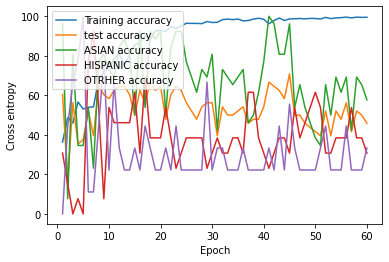

In [38]:
for i in range(len(train_acc_lst)):
    train_acc_lst[i] = train_acc_lst[i].cpu()
    
for j in range(len(test_acc_lst)):
    test_acc_lst[j] = test_acc_lst[j].cpu()

plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='test accuracy')
plt.plot(range(1, NUM_EPOCHS+1), ASIAN_ACC, label='ASIAN accuracy')
plt.plot(range(1, NUM_EPOCHS+1), HISPANIC_ACC, label='HISPANIC accuracy')
plt.plot(range(1, NUM_EPOCHS+1), OTHER_ACC, label='OTRHER accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [49]:
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix


conf_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)

with torch.no_grad():
    for idx, (features, targets) in enumerate(test_loader):

        targets = targets.squeeze()
        targets = targets.to(DEVICE)
        features = features.to(DEVICE)\

        _, pred = model_low(features)

        conf_matrix = confusion_matrix(pred, targets, conf_matrix)
        conf_matrix = conf_matrix.cpu()
            
conf_matrix=np.array(conf_matrix.cpu())# 将混淆矩阵从gpu转到cpu再转到np
corrects=conf_matrix.diagonal(offset=0)#抽取对角线的每种分类的识别正确个数
per_kinds=conf_matrix.sum(axis=1)#抽取每个分类数据总的测试条数

print("混淆矩阵总元素个数：{0},测试集总个数:{1}".format(int(np.sum(conf_matrix)),int(np.sum(conf_matrix))))
print(conf_matrix)

混淆矩阵总元素个数：48,测试集总个数:48
[[15.  4.  0.]
 [10.  4.  6.]
 [ 1.  5.  3.]]


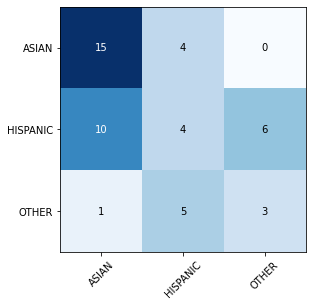

In [53]:
labels = ['ASIAN', 'HISPANIC', 'OTHER']

plt.imshow(conf_matrix, cmap = plt.cm.Blues)

thresh = conf_matrix.max() / 2
for x in range(NUM_CLASSES):
    for y in range(NUM_CLASSES):
        info = int(conf_matrix[y, x])
        plt.text(x, y, info,
                verticalalignment='center',
                horizontalalignment='center',
                color="white" if info > thresh else "black")
        
plt.tight_layout()
plt.yticks(range(NUM_CLASSES), labels)
plt.xticks(range(NUM_CLASSES), labels,rotation=45)
plt.show()
plt.close()